# 10. Stokes equation

In this tutorial, we consider the *2D* Stokes problem using $H^1(\Omega)$ discretization.

Let $\mathbf{u}$ and $p$ denote respectively the velocity and the pressure.

The Stokes problem writes

\begin{align*}
    - \nabla^2 \mathbf{u} + \nabla p &= 0 \\
    \nabla \cdot \mathbf{u} &= 0
\end{align*}

---
**note:**
The actual version of **GeLaTo** does not allow to mix scalar and vector fem spaces. We will have to use a component-wise version of the Stokes problem.

---

Let's define $\mathbf{u} = \begin{pmatrix} u_1 \\ u_2 \end{pmatrix}$

The Stokes equation writes

\begin{align*}
    - \nabla^2 u_1 + \partial_x p &= 0 \\
    - \nabla^2 u_2 + \partial_y p &= 0 \\
    \partial_x u_1 + \partial_y u_2 &= 0
\end{align*}

Let $v \in \mathcal{V}_h$ be a test function and we consider the following weak formulation

\begin{align*}
    \langle \nabla v, \nabla u_1 \rangle - \langle \partial_x  v, p \rangle &= 0 \\
    \langle \nabla v, \nabla u_2 \rangle - \langle \partial_y  v, p \rangle &= 0 \\
    \langle v, \partial_x u_1 + \partial_y u_2 \rangle &= 0
\end{align*}




In [1]:
# needed imports
from numpy import linspace, meshgrid, pi, zeros, asarray
from scipy.linalg import eig

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Math

from sympy import symbols, Symbol, Lambda, IndexedBase, Tuple
from sympy import latex

from gelato.glt import glt_symbol
from gelato.printing.latex import glt_latex
from gelato.calculus   import (Dot, Cross, Grad, Curl, Rot, Div, dx, dy)
from gelato.calculus   import Constant
from gelato.fem.assembly import assemble_matrix
from gelato.fem.utils    import compile_kernel
from gelato.fem.utils    import compile_symbol

from spl.fem.splines import SplineSpace
from spl.fem.tensor  import TensorSpace
from spl.fem.vector  import VectorFemSpace

In [2]:
x, y = symbols('x y')

u = Symbol('u')
v = Symbol('v')

epsilon = Constant('epsilon')

Laplace = lambda v,u: Dot(Grad(v), Grad(u))
Mass = lambda v,u: v*u

In [3]:
u1,u2,p = symbols('u1 u2 p')
v1,v2,q = symbols('v1 v2 q')

a = Lambda((x,y,v1,v2,q,u1,u2,p), 
             Laplace(v1,u1) - dx(v1) * p 
           + Laplace(v2,u2) - dy(v2) * p
           + q * (dx(u1) + dy(u2)) 
           + epsilon * Mass(q,p))

In [4]:
# ...  create a finite element space
p1  = 3 ; p2  = 3
ne1 = 16 ; ne2 = 16

grid_1 = linspace(0., 1., ne1+1)
grid_2 = linspace(0., 1., ne2+1)

V1 = SplineSpace(p1, grid=grid_1)
V2 = SplineSpace(p2, grid=grid_2)

V = TensorSpace(V1, V2)
# ...

# ... create a vector fem space
V = VectorFemSpace(V, V, V)
# ...

In [5]:
symbol = glt_symbol(a, space=V)

In [6]:
Math(latex(symbol))

<IPython.core.display.Math object>

In [7]:
eigen = symbol.eigenvals()
eigen = list(eigen.keys())

In [8]:
Math(latex(eigen))

<IPython.core.display.Math object>

In [9]:
# TODO not working yet 
d_types = {'epsilon': 'double'}
kernel_f90 = compile_kernel('kernel_2d', a, V, 
                            d_args=d_types, 
                            backend='fortran')

pyccel: [semantic] 
 |error: [43,29-48]| Incompatible types in assignment (|v_01| double <-> int)
 |error: [45,29-48]| Incompatible types in assignment (|v_10| double <-> int)

pyccel: [codegen] 
 |error: [43,29-48]| Incompatible types in assignment (|v_01| double <-> int)
 |error: [45,29-48]| Incompatible types in assignment (|v_10| double <-> int)



In [10]:
M = assemble_matrix(V, kernel_f90, 
                    args={'epsilon': 1.e-3})

In [11]:
from utils import coo_from_blocks

In [12]:
n_block_rows = 3 ; n_block_cols = 3
matrices = []
for ir in range(0, n_block_rows):
    line = []
    for ic in range(0, n_block_cols):
        line.append(M[ir][ic].tocoo())
    matrices.append(line)
_M = M    
M = coo_from_blocks(matrices, 
                    n_block_rows=n_block_rows, 
                    n_block_cols=n_block_cols)

In [13]:
# import eigenvalue solver
from scipy.linalg import eig

M = M.todense()
w, v = eig(M)
wr = w.real
wr.sort()

In [10]:
# TODO not working yet => complex numbers
#symbol_f90 = compile_symbol('symbol_2d', a, V, backend='fortran')

In [14]:
# TODO remove later
from gelato.glt import glt_lambdify
symbol = glt_symbol(a, space=V, evaluate=True)

symbol = symbol.subs({epsilon: 1.e-3})
f = glt_lambdify(symbol)

In [15]:
n1 = V1.nbasis
n2 = V2.nbasis
t1 = linspace(-pi,pi, n1)
t2 = linspace(-pi,pi, n2)
x1 = linspace(0.,1., n1)
x2 = linspace(0.,1., n2)

In [16]:
from numpy import imag
tol = 1.e-13

W = []
for i1 in range(0,n1):
    _x1 = x1[i1]
    _t1 = t1[i1]
    for i2 in range(0,n2):
        _x2 = x2[i2]
        _t2 = t2[i2]
        e = f(_x1,_x2,_t1,_t2)
        w,v = eig(e)
        assert([abs(imag(i)) < tol for i in w])
        W += list(w.real)
t = asarray(W)
t.sort()

In [17]:
from numpy import where
xmins = where(t < 1.e-4)
print('> len(t) = ', len(t))
print('> len(xmins) = ', len(xmins[0]))

> len(t) =  1083
> len(xmins) =  131


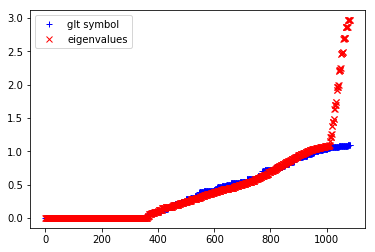

In [18]:
plt.plot(t, "+b", label="glt symbol")
plt.plot(wr, "xr", label="eigenvalues")
plt.legend(loc=2);

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()